## Access and prepare ISMN soil data: One file and single station

We load one example station from Germany (Gevenich) for the year we want to predict.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load measurements from one soil data station
# France SMOSMANIA: '/perm/dadf/HSAF_validation/in_situ_data/pre_processed_data/ismn_nc/soil_SMOSMANIA_ISMN_2008.nc'
# Germany TERENO: '/perm/dadf/HSAF_validation/in_situ_data/pre_processed_data/ismn_nc/soil_TERENO_ISMN_2022.nc'
dataset = xr.open_dataset('/perm/dadf/HSAF_validation/in_situ_data/pre_processed_data/ismn_nc/soil_TERENO_ISMN_2022.nc')
dataset
print(dataset.lat)

<xarray.DataArray 'lat' (station_id: 1)> Size: 4B
[1 values with dtype=float32]
Coordinates:
    lon         (station_id) float32 4B ...
    lat         (station_id) float32 4B ...
    network     (station_id) <U11 44B ...
  * station_id  (station_id) <U8 32B 'Gevenich'
    elevation   (station_id) float32 4B ...
    land_class  (station_id) int16 2B ...
    clim_class  (station_id) <U3 12B ...


In [2]:
print(dataset.land_class)

<xarray.DataArray 'land_class' (station_id: 1)> Size: 2B
[1 values with dtype=int16]
Coordinates:
    lon         (station_id) float32 4B ...
    lat         (station_id) float32 4B ...
    network     (station_id) <U11 44B ...
  * station_id  (station_id) <U8 32B 'Gevenich'
    elevation   (station_id) float32 4B ...
    land_class  (station_id) int16 2B ...
    clim_class  (station_id) <U3 12B ...


In [6]:
print(dataset.station_id)
print(dataset.sel(station_id = ['Gevenich']))
Gevenich = dataset.sel(station_id = ['Gevenich'])

print(Gevenich.sel(depth = [0.05, 0.2, 0.5]))
print(Gevenich.land_class.values)
print(Gevenich.clim_class.values)

<xarray.DataArray 'station_id' (station_id: 1)> Size: 32B
array(['Gevenich'], dtype='<U8')
Coordinates:
    lon         (station_id) float32 4B ...
    lat         (station_id) float32 4B ...
    network     (station_id) <U11 44B ...
  * station_id  (station_id) <U8 32B 'Gevenich'
    elevation   (station_id) float32 4B ...
    land_class  (station_id) int16 2B ...
    clim_class  (station_id) <U3 12B ...
<xarray.Dataset> Size: 526kB
Dimensions:     (time: 8760, station_id: 1, depth: 3)
Coordinates:
    lon         (station_id) float32 4B ...
    lat         (station_id) float32 4B ...
    network     (station_id) <U11 44B ...
  * station_id  (station_id) <U8 32B 'Gevenich'
    elevation   (station_id) float32 4B ...
    land_class  (station_id) int16 2B ...
    clim_class  (station_id) <U3 12B ...
  * time        (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * depth       (depth) float32 12B 0.05 0.2 0.5
Data variables:
    sm          (time, station_id, depth) float

We load the forcing data and climate fields on high resolution. 

In [3]:
forcing = xr.open_zarr("/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr").data.sel(time=slice("2022")).to_dataset()
forcing
print(forcing.lat)

<xarray.DataArray 'lat' (x: 10051)> Size: 40kB
dask.array<open_dataset-lat, shape=(10051,), dtype=float32, chunksize=(10051,), chunktype=numpy.ndarray>
Coordinates:
    lat      (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
    lon      (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
  * x        (x) int32 40kB 15653 16004 16006 16009 ... 128482 128483 128484
Attributes:
    long_name:  latitude
    units:      degrees_north


Next, we match the station with the closest grid cell in Euclidean space.

In [4]:
lat_a = dataset.lat.values  
lat_b = forcing.lat.values 
lon_a = dataset.lon.values  
lon_b = forcing.lon.values 

print(lat_a)
closest_indices = []
for lat, lon in zip(lat_a, lon_a):
    print("Get Euclidean Distance.")
    #Euclidean distance
    distances = np.sqrt((lat_b - lat)**2 + (lon_b - lon)**2)
    # closest distance
    closest_idx = distances.argmin()
    
    closest_indices.append(closest_idx)
print(closest_indices)

# select the closest grid cell to station 
closest_gridcell = forcing.isel(x=closest_indices)
print(closest_gridcell)

[50.9892]
Get Euclidean Distance.
[np.int64(4106)]
<xarray.Dataset> Size: 3MB
Dimensions:   (x: 1, time: 18744, variable: 33)
Coordinates:
    lat       (x) float32 4B 50.93
    lon       (x) float32 4B 6.573
  * time      (time) datetime64[ns] 150kB 2010-02-01 ... 2022-11-30T18:00:00
  * variable  (variable) object 264B 'met_ctpf' 'met_lwdown' ... 'slhf' 'es'
  * x         (x) int32 4B 62986
Data variables:
    data      (time, x, variable) float32 2MB ...


(8760, 1, 3)
('time', 'station_id', 'depth')
{'description': 'soil temperature at depths'}
Coordinates:
    lon         (station_id) float32 4B 6.324
    lat         (station_id) float32 4B 50.99
    network     (station_id) <U11 44B ...
  * station_id  (station_id) <U8 32B 'Gevenich'
    elevation   (station_id) float32 4B ...
    land_class  (station_id) int16 2B ...
    clim_class  (station_id) <U3 12B ...
  * time        (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * depth       (depth) float32 12B 0.05 0.2 0.5
                                         lon        lat      network  \
time                station_id depth                                   
2022-01-01 00:00:00 Gevenich   0.05   6.3236  50.989201  TERENO_ISMN   
                               0.20   6.3236  50.989201  TERENO_ISMN   
                               0.50   6.3236  50.989201  TERENO_ISMN   
2022-01-01 01:00:00 Gevenich   0.05   6.3236  50.989201  TERENO_ISMN   
                            

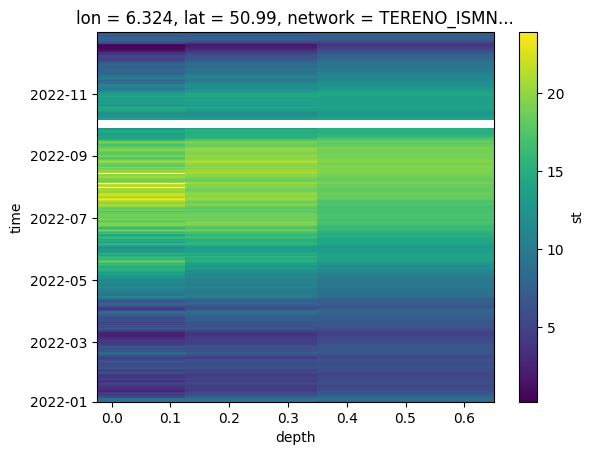

In [5]:
# Plot the soil temperature at Gevenich at 3 different layers
soil_temperature = dataset["st"] 
soil_temperature.plot()
print(soil_temperature.shape)
print(soil_temperature.dims)
print(soil_temperature.attrs)
print(soil_temperature.coords)

df = soil_temperature.to_dataframe()
print(df.head())

We look at this on an hourly resolution. We notice the large changes in the first layer towards the smoother changes with a small lag in the third layer.

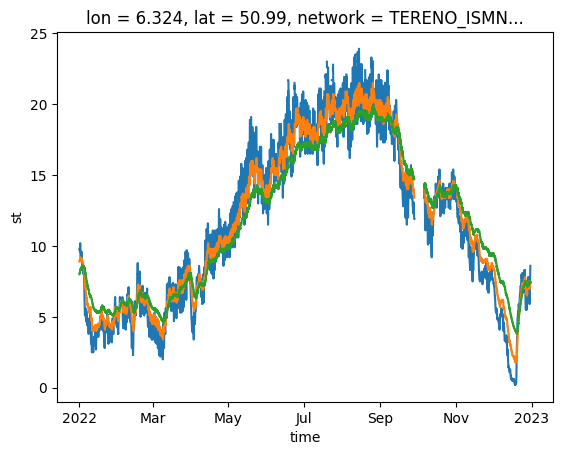

In [6]:
soil_temperature.sel(station_id="Gevenich", depth = 0.05).plot()
soil_temperature.sel(station_id="Gevenich", depth = 0.2).plot()
soil_temperature.sel(station_id="Gevenich", depth = 0.5).plot()

In [7]:
missing_count = soil_temperature.sel(station_id="Gevenich", depth = 0.05).isnull().sum()
print(f"Number of missing entries in soil temperature layer 1': {missing_count.values}")
missing_count = soil_temperature.sel(station_id="Gevenich", depth = 0.2).isnull().sum()
print(f"Number of missing entries in soil temperature layer 2': {missing_count.values}")
missing_count = soil_temperature.sel(station_id="Gevenich", depth = 0.5).isnull().sum()
print(f"Number of missing entries in soil temperature layer 3': {missing_count.values}")

Number of missing entries in soil temperature layer 1': 277
Number of missing entries in soil temperature layer 2': 221
Number of missing entries in soil temperature layer 3': 221


In [8]:
print(soil_temperature.sel(station_id="Gevenich", depth = 0.05).coords['time'][:30])

<xarray.DataArray 'time' (time: 30)> Size: 240B
array(['2022-01-01T00:00:00.000000000', '2022-01-01T01:00:00.000000000',
       '2022-01-01T02:00:00.000000000', '2022-01-01T03:00:00.000000000',
       '2022-01-01T04:00:00.000000000', '2022-01-01T05:00:00.000000000',
       '2022-01-01T06:00:00.000000000', '2022-01-01T07:00:00.000000000',
       '2022-01-01T08:00:00.000000000', '2022-01-01T09:00:00.000000000',
       '2022-01-01T10:00:00.000000000', '2022-01-01T11:00:00.000000000',
       '2022-01-01T12:00:00.000000000', '2022-01-01T13:00:00.000000000',
       '2022-01-01T14:00:00.000000000', '2022-01-01T15:00:00.000000000',
       '2022-01-01T16:00:00.000000000', '2022-01-01T17:00:00.000000000',
       '2022-01-01T18:00:00.000000000', '2022-01-01T19:00:00.000000000',
       '2022-01-01T20:00:00.000000000', '2022-01-01T21:00:00.000000000',
       '2022-01-01T22:00:00.000000000', '2022-01-01T23:00:00.000000000',
       '2022-01-02T00:00:00.000000000', '2022-01-02T01:00:00.000000000',
   

We aggregate soil temperature stations to the six-hourly mean. 

In [20]:
soil_temperature_6hr_mean = soil_temperature.resample(time='6h').mean()
print(soil_temperature_6hr_mean.head())
print(soil_temperature_6hr_mean['time'])

<xarray.DataArray 'st' (time: 5, station_id: 1, depth: 3)> Size: 60B
array([[[ 9.750001,  8.966666,  8.066667]],

       [[ 9.633333,  9.      ,  8.166667]],

       [[10.000001,  9.049999,  8.266666]],

       [[ 9.25    ,  9.166667,  8.366668]],

       [[ 9.016666,  9.033334,  8.383334]]], dtype=float32)
Coordinates:
    lon         (station_id) float32 4B 6.324
    lat         (station_id) float32 4B 50.99
    network     (station_id) <U11 44B ...
  * station_id  (station_id) <U8 32B 'Gevenich'
    elevation   (station_id) float32 4B ...
    land_class  (station_id) int16 2B ...
    clim_class  (station_id) <U3 12B ...
  * depth       (depth) float32 12B 0.05 0.2 0.5
  * time        (time) datetime64[ns] 40B 2022-01-01 ... 2022-01-02
Attributes:
    description:  soil temperature at depths
<xarray.DataArray 'time' (time: 1460)> Size: 12kB
array(['2022-01-01T00:00:00.000000000', '2022-01-01T06:00:00.000000000',
       '2022-01-01T12:00:00.000000000', ..., '2022-12-31T06:00:00.000000

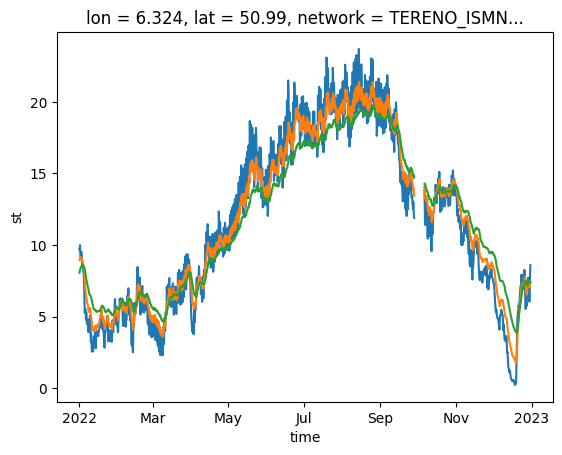

In [16]:
soil_temperature_6hr_mean.sel(station_id="Gevenich", depth = 0.05).plot()
soil_temperature_6hr_mean.sel(station_id="Gevenich", depth = 0.2).plot()
soil_temperature_6hr_mean.sel(station_id="Gevenich", depth = 0.5).plot()

In [17]:
missing_count = soil_temperature_6hr_mean.sel(station_id="Gevenich", depth = 0.05).isnull().sum()
print(f"Number of missing entries in soil temperature layer 1': {missing_count.values}")
missing_count = soil_temperature_6hr_mean.sel(station_id="Gevenich", depth = 0.2).isnull().sum()
print(f"Number of missing entries in soil temperature layer 2': {missing_count.values}")
missing_count = soil_temperature_6hr_mean.sel(station_id="Gevenich", depth = 0.5).isnull().sum()
print(f"Number of missing entries in soil temperature layer 3': {missing_count.values}")

Number of missing entries in soil temperature layer 1': 35
Number of missing entries in soil temperature layer 2': 35
Number of missing entries in soil temperature layer 3': 35


In [21]:
soil_temperature_6hr_mean_kelvin = soil_temperature_6hr_mean + 273.15
print(soil_temperature_6hr_mean_kelvin)
print(torch.tensor(soil_temperature_6hr_mean_kelvin.values))

<xarray.DataArray 'st' (time: 1460, station_id: 1, depth: 3)> Size: 18kB
array([[[282.9    , 282.11667, 281.21667]],

       [[282.78333, 282.15   , 281.31665]],

       [[283.15   , 282.19998, 281.41666]],

       ...,

       [[      nan,       nan,       nan]],

       [[      nan,       nan,       nan]],

       [[      nan,       nan,       nan]]], dtype=float32)
Coordinates:
    lon         (station_id) float32 4B 6.324
    lat         (station_id) float32 4B 50.99
    network     (station_id) <U11 44B ...
  * station_id  (station_id) <U8 32B 'Gevenich'
    elevation   (station_id) float32 4B ...
    land_class  (station_id) int16 2B ...
    clim_class  (station_id) <U3 12B ...
  * depth       (depth) float32 12B 0.05 0.2 0.5
  * time        (time) datetime64[ns] 12kB 2022-01-01 ... 2022-12-31T18:00:00
tensor([[[282.9000, 282.1167, 281.2167]],

        [[282.7833, 282.1500, 281.3167]],

        [[283.1500, 282.2000, 281.4167]],

        ...,

        [[     nan,      nan,      na

## Access and prepare ISMN soil data: Multiple files from the same station

We load one example station from Germany (Gevenich) for the year we want to predict.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

# Load measurements from one soil data station
# France SMOSMANIA: '/perm/dadf/HSAF_validation/in_situ_data/pre_processed_data/ismn_nc/soil_SMOSMANIA_ISMN_2008.nc'
# Germany TERENO: '/perm/dadf/HSAF_validation/in_situ_data/pre_processed_data/ismn_nc/soil_TERENO_ISMN_2022.nc'
file_path = '/perm/dadf/HSAF_validation/in_situ_data/pre_processed_data/ismn_nc'
file_names = ["soil_TERENO_ISMN_2021.nc", "soil_TERENO_ISMN_2022.nc"]
file_paths = [os.path.join(file_path, file_name) for file_name in file_names]

ds = xr.open_mfdataset(file_paths, combine='by_coords')

# Display the resulting dataset
print(ds)

<xarray.Dataset> Size: 1MB
Dimensions:     (time: 17520, station_id: 1, depth: 3)
Coordinates:
    lon         (station_id) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    lat         (station_id) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    network     (station_id) <U11 44B dask.array<chunksize=(1,), meta=np.ndarray>
  * station_id  (station_id) <U8 32B 'Gevenich'
    elevation   (station_id) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    land_class  (station_id) int16 2B dask.array<chunksize=(1,), meta=np.ndarray>
    clim_class  (station_id) <U3 12B dask.array<chunksize=(1,), meta=np.ndarray>
  * time        (time) datetime64[ns] 140kB 2021-01-01 ... 2022-12-31T23:00:00
  * depth       (depth) float32 12B 0.05 0.2 0.5
Data variables:
    sm          (time, station_id, depth) float32 210kB dask.array<chunksize=(8760, 1, 3), meta=np.ndarray>
    st          (time, station_id, depth) float32 210kB dask.array<chunksize=(8760, 1, 3), meta=np.ndarray>


In [3]:

import pandas as pd

t_0 = '2022-01-01T00:00:00'
n = 5  
m = 10 

t_0_datetime = pd.to_datetime(t_0)

t_0_index = ds.time.get_index('time').get_loc(t_0_datetime)
print(t_0_index)

ds_time_slice = ds.isel(time=slice(t_0_index - n, None))

# Display the resulting dataset
print(ds_time_slice)


8760
<xarray.Dataset> Size: 526kB
Dimensions:     (time: 8765, station_id: 1, depth: 3)
Coordinates:
    lon         (station_id) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    lat         (station_id) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    network     (station_id) <U11 44B dask.array<chunksize=(1,), meta=np.ndarray>
  * station_id  (station_id) <U8 32B 'Gevenich'
    elevation   (station_id) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    land_class  (station_id) int16 2B dask.array<chunksize=(1,), meta=np.ndarray>
    clim_class  (station_id) <U3 12B dask.array<chunksize=(1,), meta=np.ndarray>
  * time        (time) datetime64[ns] 70kB 2021-12-31T19:00:00 ... 2022-12-31...
  * depth       (depth) float32 12B 0.05 0.2 0.5
Data variables:
    sm          (time, station_id, depth) float32 105kB dask.array<chunksize=(5, 1, 3), meta=np.ndarray>
    st          (time, station_id, depth) float32 105kB dask.array<chunksize=(5, 1, 3), meta=np.ndarray

In [5]:
import re
network = 'soil_TERENO_ISMN_2022.nc'
new_filename = re.sub(r'(\d{4})', lambda x: str(int(x.group(1)) - 1), network)
print(new_filename)

soil_TERENO_ISMN_2021.nc
